In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [4]:
module = fc.eightb.preselection.ranked_quadh

signal = ObjIter([Tree(fn, use_gen=False) for fn in module.signal_list[::3]])

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


In [5]:
bkg = ObjIter([Tree(module.QCD_B_List, use_gen=False), Tree(module.TTJets, use_gen=False)])
# bkg = ObjIter([])
bkg.reweight(2.3)
bkg.set_systematics([0.2])

100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


[None, None]

# Event Selection
## - Trigger applied | HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5
## - Required at least 8 jets to pass preselection
## - Preselections: Jet $P_{T} > 20$ [GeV], Jet $|\eta| < 2.5$, Tight Jet ID
## - MC QCD + TTBar rescaled by $2.3\pm20\%$ to better model data
## - All X->YY->4H scaled to 1 pb, (H->bb)$^4$ branching ratio then applied

# B-Tag Multiplicities
## Investigate cuts on selecting specific B-Tag multiplicity bins
### for example: n_loose_btag == 6, or n_loose_btag == 7

100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


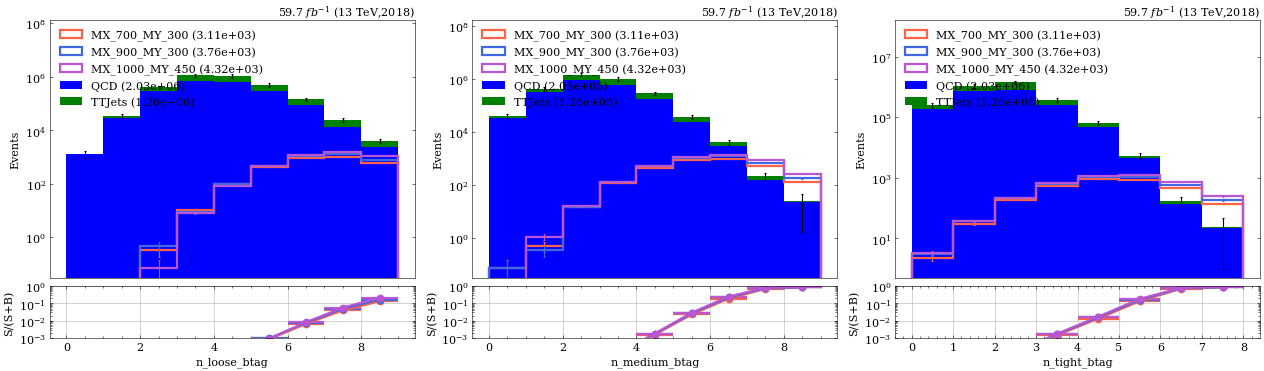

In [15]:
study.quick(
    signal+bkg, legend=True,
    log=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    dim=-1,

    ratio=True, r_inv=True, r_method='sumd', r_ylim=(1e-3,1), r_log=True,
    r_ylabel='S/(S+B)'
)

# Cumulative B-Tag Multiplicities
## Investigate cuts on selecting specific B-Tag multiplicity bins OR greater
### for example: n_loose_btag >= 6, or n_loose_btag >= 7

100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


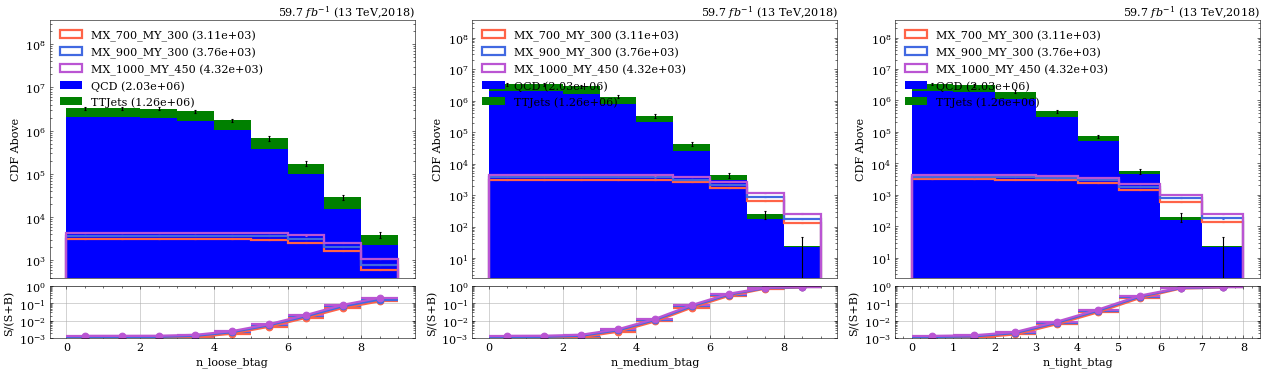

In [14]:
study.quick(
    signal+bkg, legend=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    log=True,
    dim=-1,

    cumulative=-1, 
    ratio=True, r_inv=True, r_method='sumd', r_ylim=(1e-3,1), r_log=True,
    r_ylabel='S/(S+B)'
)

# 

100%|██████████| 1/1 [00:19<00:00, 19.23s/it]


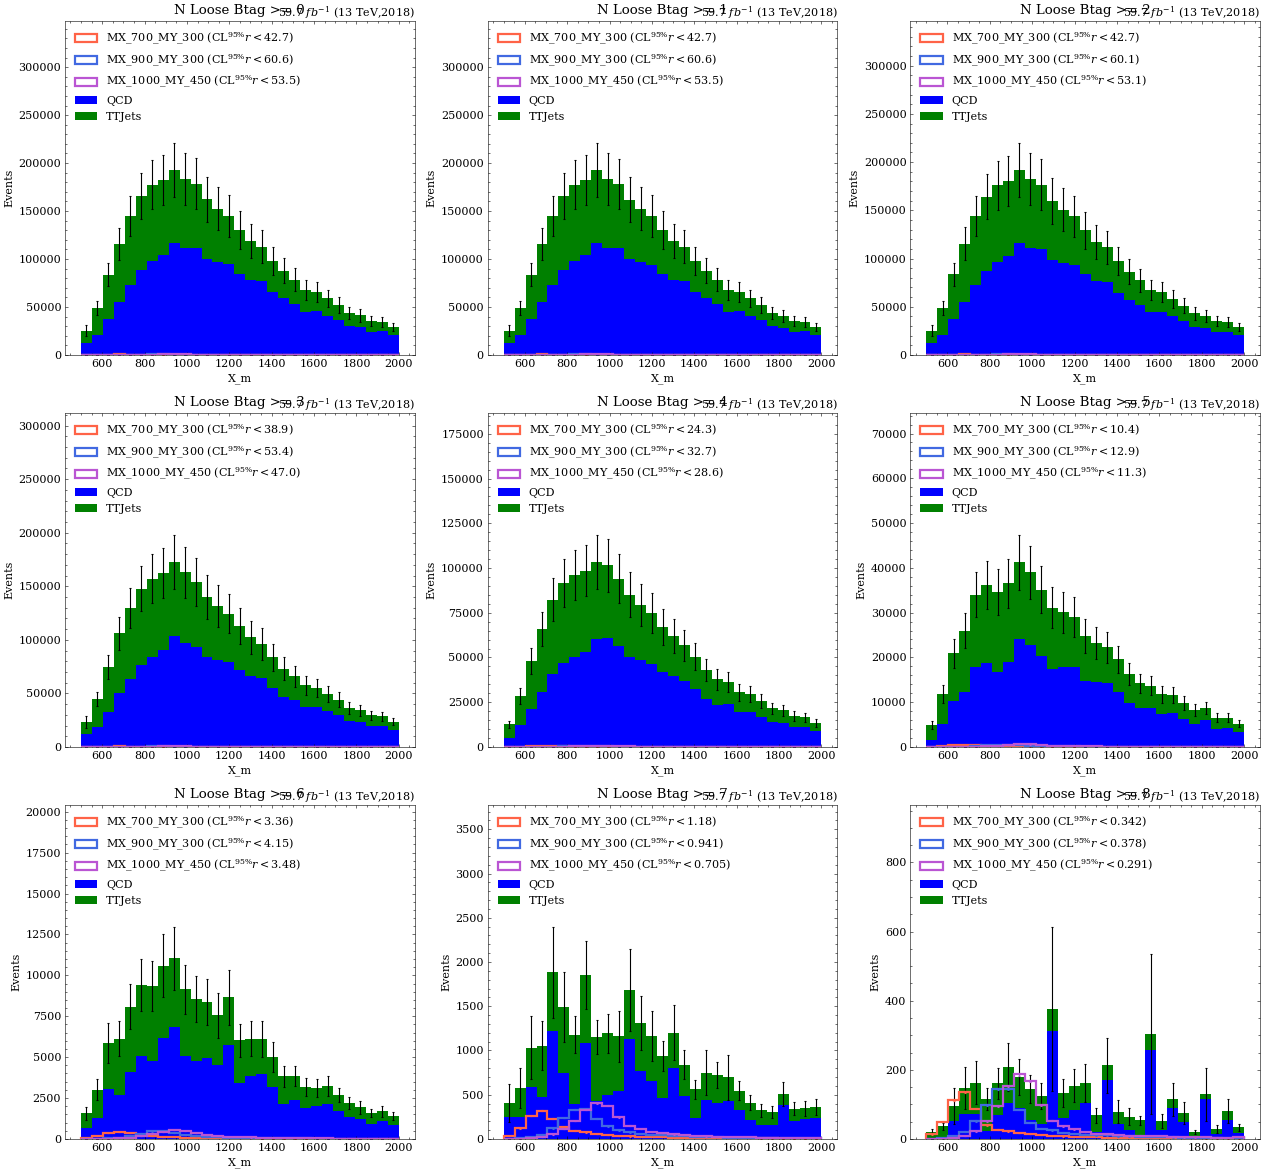

In [10]:
histos=obj_store([])

fig,axs=study.get_figax(9)
for i in range(9):
    study.quick(
        signal+bkg, legend=True,
        masks=lambda t : t.n_loose_btag >= i,
        store=histos,
        varlist=['X_m'], 
        limits=True, 
        title=f'N Loose Btag >= {i}',
        figax=(fig,axs.flat[i])
    )

In [11]:
def frac_vs_r(bkg, *sig):
    n_bkg = bkg.stats.nevents.npy.sum()
    n_sig = [ h.stats.nevents for h in sig ]
    r_sig = [ h.stats.exp_limits[2] for h in sig ]
    f_sig = [ n/(n+n_bkg) for n in n_sig ]

    return np.stack([np.array(f_sig), np.array(r_sig)]).T.reshape(3,2,1)
X = np.concatenate([ frac_vs_r(*histo) for histo in histos ], axis=-1)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

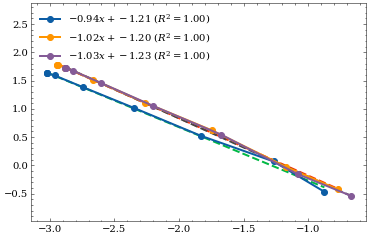

In [12]:
logX = np.log10(X)

graphs = [ Graph(x[0],x[1], fit='linear', label_stat='{fit:0.2f} ($R^2={stats.r2:0.2f}$)') for x in logX ]

plot_graphs(graphs, legend=True)

In [162]:
from scipy.optimize import fmin

for graph in graphs:
    print( 100*10**fmin(lambda x : graph.fit.func(x)**2, x0=-1.5), 10**graph.fit.func( np.log10(0.01) ) )

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 26
[5.13796351] 4.697484214350863
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 14
         Function evaluations: 28
[6.59239117] 6.822658429348784
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 14
         Function evaluations: 28
[6.3715933] 6.767209422525151


  0%|          | 0/1 [00:00<?, ?it/s]ERROR:pyhf.optimize.mixins:     fun: nan
     jac: array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])
 message: 'Inequality constraints incompatible'
    nfev: 1
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Traceback (most recent call last):
  File "/uscms_data/d3/ekoenig/mambaforge/envs/py-env/lib/python3.9/site-packages/pyhf/optimize/mixins.py", line 61, in _internal_minimize
    assert result.success
AssertionError
ERROR:pyhf.optimize.mixins:     fun: nan
     jac: array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])
 message: 'Inequality constraints incompatible'
    nfev: 1

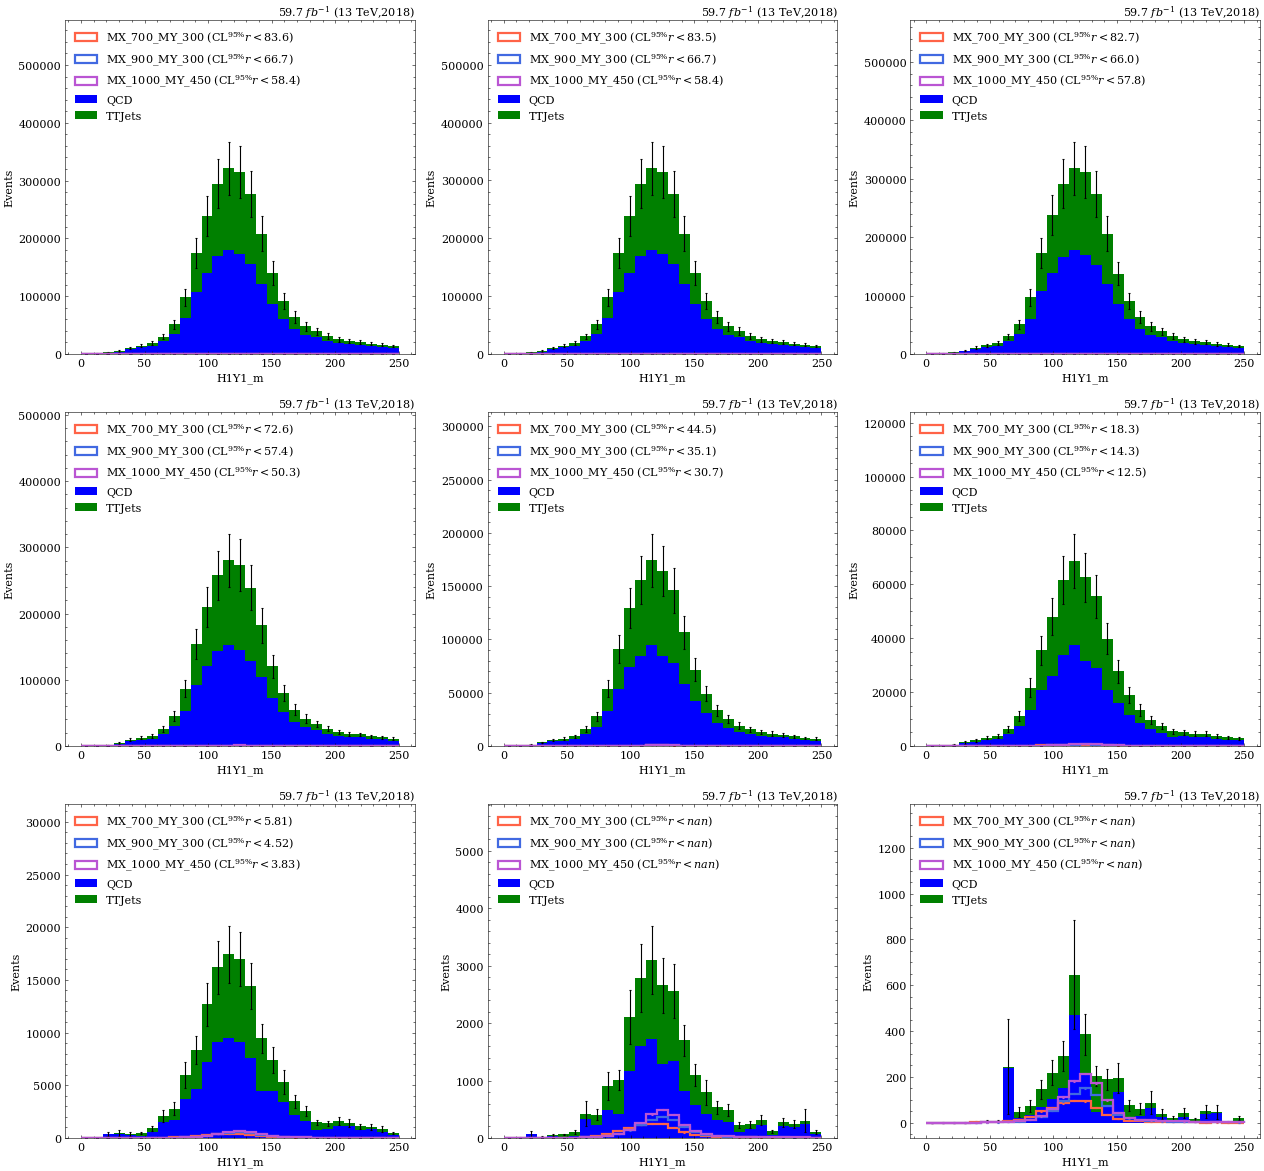

In [150]:
histos=obj_store([])

fig,axs=study.get_figax(9)
for i in range(9):
    study.quick(
        signal+bkg, legend=True,
        masks=lambda t : t.n_loose_btag >= i,
        store=histos,
        varlist=['H1Y1_m'], 
        limits=True, 
        figax=(fig,axs.flat[i])
    )

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

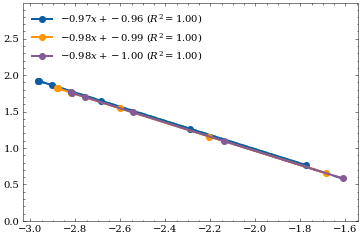

In [153]:

X = np.concatenate([ frac_vs_r(*histo) for histo in histos ], axis=-1)
logX = np.log10(X)

graphs = [ Graph(x[0],x[1], fit='linear', label_stat='{fit:0.2f} ($R^2={stats.r2:0.2f}$)') for x in logX ]

plot_graphs(graphs, legend=True)

In [157]:
from scipy.optimize import fmin

for graph in graphs:
    print( 100*10**fmin(lambda x : graph.fit.func(x)**2, x0=-1.5), 10**graph.fit.func( np.log10(0.01) ) )

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 30
[10.25504334] 9.624301240825591
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 30
[9.61197207] 9.130552029209857
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 30
[9.58445412] 9.136439187935046
